# Attempt to Code Reduced Model using Autoreduce
6.30.2020 <br>
Ankita Roychoudhury

In [1]:
from auto_reduce import *
from auto_reduce.utils import get_ODE

import numpy as np
from sympy import symbols

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

First, let's load in the SBML model. We can use a different notebook that already has this outputted.

In [3]:
# %load /Users/ankitaroychoudhury/git/ug_murray/software_module/20200629_biocrndevelop.py
# Basic Imports

#A Model is a CRN with some bells and whistles
from biocrnpyler import *
from scipy.integrate import simps
from numpy import trapz

def check_type(item, material_type_str): # call set_species
    if isinstance(item, Species):
        item_ret = item
    elif isinstance(item, str):
        item_ret = Species(name = item, material_type = material_type_str)
    elif isinstance(item, Component) and item.get_species() != None:
        item_ret = item.get_species()
    else:
        raise ValueError(item, "parameter must be a string, a Component with defined get_species(), or a chemical_reaction_network.species")
        
    return item_ret

class FuelMichaelisMenten(Mechanism):
    def __init__(self, name, type = 'catalysis', **keywords):
        
        Mechanism.__init__(self = self, name = name, mechanism_type = type, **keywords)

    def update_species(self, enzyme, fuel_list, substrate_list, product_list, waste_list): 
        
        self.enzyme = check_type(enzyme, 'enzyme')
        
        species = [self.enzyme]
        comp1_list = [self.enzyme]
        comp2_list = [self.enzyme]
        
        for f in fuel_list:
            species.append(f)
            comp1_list.append(f)

        for s in substrate_list:
            species.append(s)
            comp1_list.append(s)
            
        for p in product_list:
            species.append(p)
            comp2_list.append(p)
            
        for w in waste_list:
            species.append(w)
            comp2_list.append(w)
               
        
        species += [ComplexSpecies(comp1_list)]
        species += [ComplexSpecies(comp2_list)]
        return species
    
    def update_reactions(self, enzyme, fuel_list, substrate_list, product_list, waste_list, k_bf, k_uf, k_cat, component = None,
                        part_id = None): # component

       # k_bf = 22.68 #part_id = None
        
        #k_bf = component.get_parameter('k_bf', part_id = part_id, mechanism = self)
        
        k_br = 0.1*k_bf
       # k_uf = 24
        k_ur = 0.1*k_uf
       # k_cat = 10
       # k_atp_use = 0.5
       # print(enzyme)
        self.enzyme = check_type(enzyme, 'enzyme')
        
        
        comp1_list = [self.enzyme]
        comp2_list = [self.enzyme]


        for f in fuel_list:
            comp1_list.append(f)
            
        for s in substrate_list:
            comp1_list.append(s)

        for p in product_list:
            comp2_list.append(p)
            
        for w in waste_list:
            comp2_list.append(w)
        
        comp1 = ComplexSpecies(comp1_list)
        comp2 = ComplexSpecies(comp2_list)
        
        binding_rxn = Reaction(inputs = comp1_list, outputs=[comp1], k = k_bf, k_rev = k_br)
        cat_rxn = Reaction(inputs = [comp1], outputs = [comp2], k = k_cat)
        unbinding_rxn = Reaction(inputs = [comp2], outputs = comp2_list, k=k_uf, k_rev = k_ur)
        
        return [binding_rxn, cat_rxn, unbinding_rxn]
    
    
class Enzyme(Component):
    def __init__(self, enzyme_name, substrate, fuel, product, waste, k_bf, k_uf, k_cat = 36000, **keywords):
      
        # ENZYME NAME
        # self.enzyme = self.set_species()
        self.enzyme = check_type(enzyme_name, 'enzyme')
    
        # SUBSTRATE
        self.substrate_list = []
        for s in substrate:
            self.substrate_list.append(self.set_species(s, material_type = 'molecule'))
            
#         for s in substrate:
#             setattr(self, f'{s}', check_type(s, 'molecule'))
#             substrate_list.append(getattr(self, f'{s}'))
            
#         self.substrate_list = substrate_list
        
        
        # FUEL
        
        self.fuel_list = []
        for f in fuel:
            self.fuel_list.append(self.set_species(f, material_type ='metabolite'))
        
        
        
        # PRODUCT
        self.product_list = []
        for p in product:
            self.product_list.append(self.set_species(p, material_type = 'molecule'))
          
            
        # WASTE
        self.waste_list = []
        for w in waste:
            self.waste_list.append(self.set_species(w, material_type = 'metabolite'))
        
        
        self.k_bf = k_bf
        self.k_uf = k_uf
        self.k_cat = k_cat
        
            
        
      
        Component.__init__(self = self, name = enzyme_name, **keywords)
        
    def update_species(self):
        mech_cat = self.mechanisms['catalysis']
        
            
        
        return mech_cat.update_species(self.enzyme, self.fuel_list, self.substrate_list, self.product_list, self.waste_list) 
                                                                                           
    
    def update_reactions(self):
        mech_cat = self.mechanisms['catalysis']

        
        return mech_cat.update_reactions(self.enzyme, self.fuel_list, self.substrate_list, self.product_list, self.waste_list,self.k_bf,
                                         self.k_uf, self.k_cat,component = None,  part_id = None) # for parameters
#component = self,  part_id = self.name


class EnergyTxTl(Mixture):
    def __init__(self, name="",**keywords): 
        

        mech_cat = FuelMichaelisMenten('catalysis')
        
        default_mechanisms = {
            mech_cat.mechanism_type:mech_cat
        }
        
        #species = [self.enzyme]
        Mixture.__init__(self, name = name, default_mechanisms=default_mechanisms, **keywords) 
        #  parameter_file = 'parameters.txt'
    


def plot_entire_with_enzymes(k_bf, k_uf, k_cat_atp, enz_init, glucose_init, atp_init, pi_init, nadp_init, atpase_init, 
                             t_max, bpg_13 = 0,
                            area_isobss = False):

    k_bf = k_bf #20 #660
    k_uf = k_uf #20 #144 # per hour

    #

    E1_hex = Enzyme(enzyme_name = "hex", substrate = ['glucose'],
                fuel = ['atp'],product = ['g6p'], waste = ['adp'], k_bf = k_bf , k_uf = k_uf)

    E2_pgi = Enzyme(enzyme_name = 'pgi', substrate = ['g6p'], fuel = [],
               product = ['f6p'], waste = [], k_bf = k_bf , k_uf = k_uf)

    E3_pfk = Enzyme(enzyme_name = 'pfk', substrate = ['f6p'], fuel = ['atp'], product = ['f16p'],
               waste = ['adp'], k_bf = k_bf , k_uf = k_uf)

    E4_ald_tpi = Enzyme(enzyme_name ='ald_tpi' , substrate = ['f16p'], fuel = [], product = ['g3p', 'g3p'], 
                waste = [], k_bf = k_bf , k_uf = k_uf )

    E5_gapN = Enzyme(enzyme_name ='gapN' , substrate = ['g3p', 'g3p'], fuel = ['nadp', 'nadp'], product = ['3pg', '3pg'], 
                waste = ['nadph', 'nadph'], k_bf = k_bf , k_uf = k_uf)

    E6_mGapDH = Enzyme(enzyme_name ='mGapDH' , substrate = ['g3p', 'g3p'], fuel = ['pi', 'nadp', 'nadp'], product = ['13bpg'], 
                waste = ['nadph', 'nadph'],k_bf = k_bf , k_uf = k_uf)

    E7_pgk = Enzyme(enzyme_name = 'pgk', substrate = ['13bpg'], fuel = ['adp'], product = ['3pg', '3pg'], 
                waste = ['atp'], k_bf = k_bf , k_uf = k_uf)

    E8_pgm = Enzyme(enzyme_name ='pgm' , substrate = ['3pg', '3pg'], fuel = [], product = ['2pg', '2pg'], 
                waste = [], k_bf = k_bf , k_uf = k_uf)

    E9_eno = Enzyme(enzyme_name ='eno' , substrate = ['2pg', '2pg'], fuel = [], product = ['pep', 'pep'], 
                waste = [],k_bf = k_bf , k_uf = k_uf)

    E10_pyk = Enzyme(enzyme_name = 'pyk', substrate = ['pep', 'pep'], fuel = ['adp', 'adp'], product = ['pyruvate', 'pyruvate'], 
                waste = ['atp', 'atp'], k_bf = k_bf , k_uf = k_uf) # irreversible

    E11_alsS = Enzyme(enzyme_name = 'alsS', substrate = ['pyruvate', 'pyruvate'], fuel = [], product = ['acetolac'], 
                waste = [], k_bf = k_bf , k_uf = k_uf) # irreversible

    E12_IlvC = Enzyme(enzyme_name = 'IlvC', substrate = ['acetolac'], fuel = ['nadph'], product = ['23dih3mebut'], 
                waste = ['nadp'], k_bf = k_bf , k_uf = k_uf)

    E13_IlvD = Enzyme(enzyme_name ='IlvD' , substrate = ['23dih3mebut'], fuel = [], product = ['3me2oxo'], 
                waste = [],k_bf = k_bf , k_uf = k_uf)

    E14_kivD = Enzyme(enzyme_name ='kivD' , substrate = ['3me2oxo'], fuel = [], product = ['isobutanal'], 
                waste = [], k_bf = k_bf , k_uf = k_uf) # irreversible

    E15_yahk = Enzyme(enzyme_name = 'yahk', substrate = ['isobutanal'], fuel = ['nadph'], product = ['isobutanol'],
                      waste = ['nadp'], k_bf = k_bf , k_uf = k_uf)
    
    E16_atpase = Enzyme(enzyme_name = 'atpase', substrate = [], fuel = ['atp'], product = [],
                        waste = ['adp', 'pi'], k_bf = k_bf, k_uf = k_uf, k_cat = k_cat_atp)


#     E16_all_other_atp = Enzyme(enzyme_name = 'atp_synthase', substrate = [], fuel = ['atp'], 
#                                product = [], waste = ['adp', 'pi'], k_bf = k_bf, k_uf = k_uf, k_cat = 1,)

    myMixture = EnergyTxTl(components = [E1_hex,E2_pgi,E3_pfk, E4_ald_tpi, E5_gapN, E6_mGapDH, E7_pgk, E8_pgm, E9_eno, E10_pyk, 
                                        E11_alsS, E12_IlvC, E13_IlvD, E14_kivD, E15_yahk, E16_atpase])
    myMixture_atp = EnergyTxTl(components = [E16_atpase])
    
    CRN = myMixture.compile_crn()
    CRN_atp = myMixture_atp.compile_crn()


    
   #  CRN.write_sbml_file("CRN.sbml")
    # CRN_atp.write_sbml_file("CRN_atp.sbml")
    
    timepoints = np.linspace(0,t_max,t_max)
    
    e = enz_init #0.15
    #e4 = 3.5
    atp = atp_init #30
    pi = pi_init
    atpase = atpase_init
    x0 = {'molecule_glucose':glucose_init, #30,
          'metabolite_atp': atp,
         'metabolite_nadp':nadp_init,
          'metabolite_pi':pi,
          'molecule_13bpg':bpg_13,
          "enzyme_hex":e,
          'enzyme_pgi':e,
          'enzyme_pfk':e,
          'enzyme_ald_tpi':e,
          'enzyme_gapN':e, 
          'enzyme_mGapDH':e,
          'enzyme_pgk':e,
          'enzyme_pgm':e,
          'enzyme_eno':e,
          'enzyme_pyk':e,
          'enzyme_alsS':e,
          'enzyme_IlvC':e,
          'enzyme_IlvD':e,
          'enzyme_kivD':e,
          'enzyme_yahk':e,
          'enzyme_atpase':atpase
        #  "enzyme_atp_synthase":e4
    }
    x0_atp = {'metabolite_atp': atp,
               'enzyme_atpase':atpase
        #  "enzyme_atp_synthase":e4
    }

    re = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
    re_atp = CRN_atp.simulate_with_bioscrape(timepoints, initial_condition_dict = x0_atp)


        # same color scheme as the others for presentation
    colors=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
    #colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

    # First plot glucose and isobutanol
    p3_complex = bokeh.plotting.figure(width = 450, height = 250, 
                             x_axis_label = 'time',
                             y_axis_label = 'concentration (mM)',
                             title = 'Entire Pathway Biocrnpyler')
    p3_complex.line(timepoints, re['molecule_glucose'], color = colors[0],line_width = 2, legend_label = 'glucose')
    p3_complex.line(timepoints, re['molecule_isobutanol'], color = colors[1], line_width = 2,legend_label = 'isobutanol')
    p3_complex.line(timepoints, re['molecule_f16p'], color = colors[2], line_width = 2,legend_label = 'f16p')
    p3_complex.legend.location = 'center_right'
    p3_complex.legend.click_policy="hide"


    # Plot ATP and ADP, Pi
    p4_complex = bokeh.plotting.figure(width = 450, height = 250,
                               x_axis_label = 'time (hrs)',
                             y_axis_label = 'concentration (mM)',
                                      title = 'ATP Compare')
#     p4_complex.line(timepoints, re['molecule_glucose'], color = colors[0],# 0
#                     line_width = 1.5, legend_label = 'glucose')


    p4_complex.line(timepoints, re['metabolite_atp'], color = colors[3], line_width = 1.5,legend_label = 'atp')
    p4_complex.line(timepoints, re_atp['metabolite_atp'], legend_label = 'atp only',line_width=2, color = colors[4])


    p4_complex.line(timepoints, re['metabolite_pi'], color = 'bisque',line_width = 2, legend_label = 'pi')#colors[6]
    p4_complex.line(timepoints, re['metabolite_adp'], color = 'burlywood', line_width = 2,legend_label = 'adp')#colors[5]
    p4_complex.legend.location = 'center_right'
    p4_complex.legend.click_policy="hide"
    
    p5_enzyme = bokeh.plotting.figure(width = 650, height = 500,
                               x_axis_label = 'time (hrs)',
                             y_axis_label = 'concentration (mM)',
                                     title = 'All Enzymes')
    
    enz_color = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']
    enz_color2 = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
    p5_enzyme.line(timepoints, re['enzyme_hex'], color = enz_color[0],line_width = 2, legend_label = 'hex')
    p5_enzyme.line(timepoints, re['enzyme_pgi'], color = enz_color[1],line_width = 2, legend_label = 'pgi')
    p5_enzyme.line(timepoints, re['enzyme_pfk'], color = enz_color[2],line_width = 2, legend_label = 'pfk')
    p5_enzyme.line(timepoints, re['enzyme_ald_tpi'], color = enz_color[3],line_width = 2, legend_label = 'ald_tpi')
    p5_enzyme.line(timepoints, re['enzyme_gapN'], color = enz_color[4],line_width = 2, legend_label = 'gapN')
    p5_enzyme.line(timepoints, re['enzyme_mGapDH'], color = enz_color[5],line_width = 2, legend_label = 'mgapdh')
    p5_enzyme.line(timepoints, re['enzyme_pgk'], color = enz_color[6],line_width = 2, legend_label = 'pgk')
    p5_enzyme.line(timepoints, re['enzyme_pgm'], color = enz_color[7],line_width = 2, legend_label = 'pgm')
    p5_enzyme.line(timepoints, re['enzyme_eno'], color = enz_color[8],line_width = 2, legend_label = 'eno')
    p5_enzyme.line(timepoints, re['enzyme_pyk'], color = enz_color[9],line_width = 2, legend_label = 'pyk')
    p5_enzyme.line(timepoints, re['enzyme_alsS'], color = enz_color[10],line_width = 2, legend_label = 'alsS')
    p5_enzyme.line(timepoints, re['enzyme_IlvC'], color = enz_color[11],line_width = 2, legend_label = 'IlvC')
    p5_enzyme.line(timepoints, re['enzyme_IlvD'], color = enz_color2[0],line_width = 2, legend_label = 'IlvD')
    p5_enzyme.line(timepoints, re['enzyme_kivD'], color = enz_color2[1],line_width = 2, legend_label = 'kivD')
    p5_enzyme.line(timepoints, re['enzyme_yahk'], color = enz_color2[2],line_width = 2, legend_label = 'yahk')
    p5_enzyme.line(timepoints, re['enzyme_atpase'], color = enz_color2[3],line_width = 2, legend_label = 'atpase from rheostat + leak')
    p5_enzyme.line(timepoints, re_atp['enzyme_atpase'], color = enz_color2[4],line_width = 2, legend_label = 'atpase from leak only')

    p5_enzyme.legend.click_policy="hide"

    if area_isobss == False:
    
        # Find area under atp curve
        y = re['metabolite_atp'].values
        dx = timepoints[1] - timepoints[0]
        area1 = trapz(y, dx=dx)
        print('area atp pink',area1)

        # Find area under atp only curve
        y2 = re_atp['metabolite_atp'].values
        area2 = trapz(y2, dx=dx)
        print('area atp only green', area2)
        #print("area2", area2)


        #bokeh.io.show(row(p3_complex,p4_complex))
        return p3_complex,p4_complex, p5_enzyme,re
        #return area1
        
    elif area_isobss == True:
        y = re['metabolite_atp'].values
        dx = timepoints[1] - timepoints[0]
        area1 = trapz(y, dx=dx)
        
        isob_ss = re['molecule_isobutanol'][t_max]
        
        return area1, isob_ss
    
    
    
    
def return_df(k_bf, k_uf, k_cat_atp, enz_init, glucose_init, atp_init, pi_init, nadp_init, atpase_init, 
                             t_max, bpg_13 = 0,
                            area_isobss = False):

    k_bf = k_bf #20 #660
    k_uf = k_uf #20 #144 # per hour

    #

    E1_hex = Enzyme(enzyme_name = "hex", substrate = ['glucose'],
                fuel = ['atp'],product = ['g6p'], waste = ['adp'], k_bf = k_bf , k_uf = k_uf)

    E2_pgi = Enzyme(enzyme_name = 'pgi', substrate = ['g6p'], fuel = [],
               product = ['f6p'], waste = [], k_bf = k_bf , k_uf = k_uf)

    E3_pfk = Enzyme(enzyme_name = 'pfk', substrate = ['f6p'], fuel = ['atp'], product = ['f16p'],
               waste = ['adp'], k_bf = k_bf , k_uf = k_uf)

    E4_ald_tpi = Enzyme(enzyme_name ='ald_tpi' , substrate = ['f16p'], fuel = [], product = ['g3p', 'g3p'], 
                waste = [], k_bf = k_bf , k_uf = k_uf )

    E5_gapN = Enzyme(enzyme_name ='gapN' , substrate = ['g3p', 'g3p'], fuel = ['nadp', 'nadp'], product = ['3pg', '3pg'], 
                waste = ['nadph', 'nadph'], k_bf = k_bf , k_uf = k_uf)

    E6_mGapDH = Enzyme(enzyme_name ='mGapDH' , substrate = ['g3p', 'g3p'], fuel = ['pi', 'nadp', 'nadp'], product = ['13bpg'], 
                waste = ['nadph', 'nadph'],k_bf = k_bf , k_uf = k_uf)

    E7_pgk = Enzyme(enzyme_name = 'pgk', substrate = ['13bpg'], fuel = ['adp'], product = ['3pg', '3pg'], 
                waste = ['atp'], k_bf = k_bf , k_uf = k_uf)

    E8_pgm = Enzyme(enzyme_name ='pgm' , substrate = ['3pg', '3pg'], fuel = [], product = ['2pg', '2pg'], 
                waste = [], k_bf = k_bf , k_uf = k_uf)

    E9_eno = Enzyme(enzyme_name ='eno' , substrate = ['2pg', '2pg'], fuel = [], product = ['pep', 'pep'], 
                waste = [],k_bf = k_bf , k_uf = k_uf)

    E10_pyk = Enzyme(enzyme_name = 'pyk', substrate = ['pep', 'pep'], fuel = ['adp', 'adp'], product = ['pyruvate', 'pyruvate'], 
                waste = ['atp', 'atp'], k_bf = k_bf , k_uf = k_uf) # irreversible

    E11_alsS = Enzyme(enzyme_name = 'alsS', substrate = ['pyruvate', 'pyruvate'], fuel = [], product = ['acetolac'], 
                waste = [], k_bf = k_bf , k_uf = k_uf) # irreversible

    E12_IlvC = Enzyme(enzyme_name = 'IlvC', substrate = ['acetolac'], fuel = ['nadph'], product = ['23dih3mebut'], 
                waste = ['nadp'], k_bf = k_bf , k_uf = k_uf)

    E13_IlvD = Enzyme(enzyme_name ='IlvD' , substrate = ['23dih3mebut'], fuel = [], product = ['3me2oxo'], 
                waste = [],k_bf = k_bf , k_uf = k_uf)

    E14_kivD = Enzyme(enzyme_name ='kivD' , substrate = ['3me2oxo'], fuel = [], product = ['isobutanal'], 
                waste = [], k_bf = k_bf , k_uf = k_uf) # irreversible

    E15_yahk = Enzyme(enzyme_name = 'yahk', substrate = ['isobutanal'], fuel = ['nadph'], product = ['isobutanol'],
                      waste = ['nadp'], k_bf = k_bf , k_uf = k_uf)
    
    E16_atpase = Enzyme(enzyme_name = 'atpase', substrate = [], fuel = ['atp'], product = [],
                        waste = ['adp', 'pi'], k_bf = k_bf, k_uf = k_uf, k_cat = k_cat_atp)


#     E16_all_other_atp = Enzyme(enzyme_name = 'atp_synthase', substrate = [], fuel = ['atp'], 
#                                product = [], waste = ['adp', 'pi'], k_bf = k_bf, k_uf = k_uf, k_cat = 1,)

    myMixture = EnergyTxTl(components = [E1_hex,E2_pgi,E3_pfk, E4_ald_tpi, E5_gapN, E6_mGapDH, E7_pgk, E8_pgm, E9_eno, E10_pyk, 
                                        E11_alsS, E12_IlvC, E13_IlvD, E14_kivD, E15_yahk, E16_atpase])
    myMixture_atp = EnergyTxTl(components = [E16_atpase])
    
    CRN = myMixture.compile_crn()
    CRN_atp = myMixture_atp.compile_crn()


    
   #  CRN.write_sbml_file("CRN.sbml")
    # CRN_atp.write_sbml_file("CRN_atp.sbml")
    
    timepoints = np.linspace(0,t_max,100)
    
    e = enz_init #0.15
    #e4 = 3.5
    atp = atp_init #30
    pi = pi_init
    atpase = atpase_init
    x0 = {'molecule_glucose':glucose_init, #30,
          'metabolite_atp': atp,
         'metabolite_nadp':nadp_init,
          'metabolite_pi':pi,
          'molecule_13bpg':bpg_13,
          "enzyme_hex":e,
          'enzyme_pgi':e,
          'enzyme_pfk':e,
          'enzyme_ald_tpi':e,
          'enzyme_gapN':e, 
          'enzyme_mGapDH':e,
          'enzyme_pgk':e,
          'enzyme_pgm':e,
          'enzyme_eno':e,
          'enzyme_pyk':e,
          'enzyme_alsS':e,
          'enzyme_IlvC':e,
          'enzyme_IlvD':e,
          'enzyme_kivD':e,
          'enzyme_yahk':e,
          'enzyme_atpase':atpase
        #  "enzyme_atp_synthase":e4
    }
    x0_atp = {'metabolite_atp': atp,
               'enzyme_atpase':atpase
        #  "enzyme_atp_synthase":e4
    }

    re = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0)
    re_atp = CRN_atp.simulate_with_bioscrape(timepoints, initial_condition_dict = x0_atp)

    return re, timepoints
   
    
def get_SBML(k_bf, k_uf, k_cat_atp):

    k_bf = k_bf #20 #660
    k_uf = k_uf #20 #144 # per hour

    #

    E1_hex = Enzyme(enzyme_name = "hex", substrate = ['glucose'],
                fuel = ['atp'],product = ['g6p'], waste = ['adp'], k_bf = k_bf , k_uf = k_uf)

    E2_pgi = Enzyme(enzyme_name = 'pgi', substrate = ['g6p'], fuel = [],
               product = ['f6p'], waste = [], k_bf = k_bf , k_uf = k_uf)

    E3_pfk = Enzyme(enzyme_name = 'pfk', substrate = ['f6p'], fuel = ['atp'], product = ['f16p'],
               waste = ['adp'], k_bf = k_bf , k_uf = k_uf)

    E4_ald_tpi = Enzyme(enzyme_name ='ald_tpi' , substrate = ['f16p'], fuel = [], product = ['g3p', 'g3p'], 
                waste = [], k_bf = k_bf , k_uf = k_uf )

    E5_gapN = Enzyme(enzyme_name ='gapN' , substrate = ['g3p', 'g3p'], fuel = ['nadp', 'nadp'], product = ['3pg', '3pg'], 
                waste = ['nadph', 'nadph'], k_bf = k_bf , k_uf = k_uf)

    E6_mGapDH = Enzyme(enzyme_name ='mGapDH' , substrate = ['g3p', 'g3p'], fuel = ['pi', 'nadp', 'nadp'], product = ['13bpg'], 
                waste = ['nadph', 'nadph'],k_bf = k_bf , k_uf = k_uf)

    E7_pgk = Enzyme(enzyme_name = 'pgk', substrate = ['13bpg'], fuel = ['adp'], product = ['3pg', '3pg'], 
                waste = ['atp'], k_bf = k_bf , k_uf = k_uf)

    E8_pgm = Enzyme(enzyme_name ='pgm' , substrate = ['3pg', '3pg'], fuel = [], product = ['2pg', '2pg'], 
                waste = [], k_bf = k_bf , k_uf = k_uf)

    E9_eno = Enzyme(enzyme_name ='eno' , substrate = ['2pg', '2pg'], fuel = [], product = ['pep', 'pep'], 
                waste = [],k_bf = k_bf , k_uf = k_uf)

    E10_pyk = Enzyme(enzyme_name = 'pyk', substrate = ['pep', 'pep'], fuel = ['adp', 'adp'], product = ['pyruvate', 'pyruvate'], 
                waste = ['atp', 'atp'], k_bf = k_bf , k_uf = k_uf) # irreversible

    E11_alsS = Enzyme(enzyme_name = 'alsS', substrate = ['pyruvate', 'pyruvate'], fuel = [], product = ['acetolac'], 
                waste = [], k_bf = k_bf , k_uf = k_uf) # irreversible

    E12_IlvC = Enzyme(enzyme_name = 'IlvC', substrate = ['acetolac'], fuel = ['nadph'], product = ['23dih3mebut'], 
                waste = ['nadp'], k_bf = k_bf , k_uf = k_uf)

    E13_IlvD = Enzyme(enzyme_name ='IlvD' , substrate = ['23dih3mebut'], fuel = [], product = ['3me2oxo'], 
                waste = [],k_bf = k_bf , k_uf = k_uf)

    E14_kivD = Enzyme(enzyme_name ='kivD' , substrate = ['3me2oxo'], fuel = [], product = ['isobutanal'], 
                waste = [], k_bf = k_bf , k_uf = k_uf) # irreversible

    E15_yahk = Enzyme(enzyme_name = 'yahk', substrate = ['isobutanal'], fuel = ['nadph'], product = ['isobutanol'],
                      waste = ['nadp'], k_bf = k_bf , k_uf = k_uf)
    
    E16_atpase = Enzyme(enzyme_name = 'atpase', substrate = [], fuel = ['atp'], product = [],
                        waste = ['adp', 'pi'], k_bf = k_bf, k_uf = k_uf, k_cat = k_cat_atp)


#     E16_all_other_atp = Enzyme(enzyme_name = 'atp_synthase', substrate = [], fuel = ['atp'], 
#                                product = [], waste = ['adp', 'pi'], k_bf = k_bf, k_uf = k_uf, k_cat = 1,)

    myMixture = EnergyTxTl(components = [E1_hex,E2_pgi,E3_pfk, E4_ald_tpi, E5_gapN, E6_mGapDH, E7_pgk, E8_pgm, E9_eno, E10_pyk, 
                                        E11_alsS, E12_IlvC, E13_IlvD, E14_kivD, E15_yahk, E16_atpase])
    myMixture_atp = EnergyTxTl(components = [E16_atpase])
    
    CRN = myMixture.compile_crn()
    CRN_atp = myMixture_atp.compile_crn()


    
    CRN.write_sbml_file("CRN.xml")
    # CRN_atp.write_sbml_file("CRN_atp.sbml")
    
    return None
    
 

In [4]:
# This saves a CRN.xml in the reduced_model directory
k_bf = 15
k_uf = 15
k_cat_atp = 2 
get_SBML(k_bf, k_uf, k_cat_atp)

Now, let's try to follow the pattern of the autoreduce notebooks to get our reduced model working.
To start off, let's see if we can implement on a super simple pathway: <br>
$$Glucose + ATP + Hex \leftrightarrow^{kbf,hex}_{kbr,hex} Glucose:ATP:Hex \leftrightarrow^{kcatf,hex}_{kcatr,hex} G6P:ADP:Hex \leftrightarrow^{kuf,hex}_{kur,hex} G6P + ADP + Hex$$<br>
$$G6P + Pgi \leftrightarrow^{kbf,pgi}_{kbr,pgi} G6P:Pgi \leftrightarrow^{kcatf,pgi}_{kcatr,pgi} F6P:Pgi \leftrightarrow^{kuf,pgi}_{kur,pgi} F6P + Pgi$$ <br>
Our main input is Glucose and the main output is F6P.

$$F + S + E \leftrightarrow^{kbf}_{kbr} F:S:E \rightarrow^{kcat} W:P:E \leftrightarrow^{kuf}_{kur} W + P + E$$ <br>

Now, let's define some functions to help us with defining functions etc.

In [2]:
def define_params(val, inds, P_list):
    '''Val: the value that a particular parameter will take,
    inds: list input, the indices of P_list that will take this parameter,
    P_list: the list to change'''
    
    for ind in inds:
        P_list[ind] = val
    
    return P_list


In [4]:
#def get_f(fuel, substrate, enzyme, waste, product, ind, f_list)

SyntaxError: unexpected EOF while parsing (<ipython-input-4-89df1f08a4b0>, line 2)

In [3]:
n = 11
nouts = 1 # only f6p
# Not implemented error
#sys.load_SBML_model('CRN.xml')

In [5]:
# Parameter values
P = np.zeros(12)
P[0] = 15 #kbf,hex
P[1] = 1.5 #kbr,hex
P[2] = 36000 #kcatf,hex
P[3] = 0.00001 #kcatr,hex
P[4] = 15 #kuf,hex
P[5] = 1.5 #kur,hex

P[6] = 15 #kbf,pgi
P[7] = 1.5 #kbr,pgi
P[8] = 36000 #kcatf,pgi
P[9] = 0.00001 #kcatr,pgi
P[10] = 15 #kuf,pgi
P[11] = 1.5 #kur,pgi

print(P)
params_values = P.copy()
timepoints_ode = np.linspace(0,72,100)

x_init = np.ones(n) # initial conditions for glucose,atp,hex

error_tol = 100
nstates_tol = 1

x,f,P = system.load_ODE_model(n, len(params_values))
params = P



[1.5e+01 1.5e+00 3.6e+04 1.0e-05 1.5e+01 1.5e+00 1.5e+01 1.5e+00 3.6e+04
 1.0e-05 1.5e+01 1.5e+00]


In [12]:
params_values

array([1.5e+01, 1.5e+00, 3.6e+04, 1.0e-05, 1.5e+01, 1.5e+00, 1.5e+01,
       1.5e+00, 3.6e+04, 1.0e-05, 1.5e+01, 1.5e+00])

In [11]:
P[0]

P0

In [9]:
x

[x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]

In [7]:
f

[f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10]

In [13]:
# Write all functions as massaction
# x[0] = glucose
# x[1] = atp
# x[2] = hex
# x[3] = glu:atp:hex
# x[4] = g6p:adp:hex
# x[5] = G6P
# x[6] = ADP
# x[7] = Pgi
# x[8] = G6P:pgi
# x[9] = f6p:pgi
# x[10] = f6p
f[0] = -P[0] * x[0] * x[1] * x[2] + P[1] * x[3] #for Glucose
f[1] = -P[0] * x[0] * x[1] * x[2] + P[1] * x[3] # for ATP
f[2] = -P[0] * x[0] * x[1] * x[2] + P[1] * x[3] + P[4] * x[4] - P[5] * x[5] * x[6] * x[2]# for Hex
f[3] = +P[0] * x[0] * x[1] * x[2] - P[1] * x[3] - P[8] * x[3] + P[3] * x[4]# for glu:atp:hex
f[4] = +P[2] * x[3] - P[3] * x[4] - P[4] * x[4] + P[5] * x[5] * x[6] * x[2]# for g6p:adp:hex
f[5] = +P[4] * x[4] - P[5] * x[5] * x[6] * x[2] - P[6] * x[5] * x[7] + P[10] * x[8]# for g6p
f[6] = +P[4] * x[4] - P[5] * x[5] * x[6] * x[2]# for adp

f[7] = -P[6] * x[5] * x[7] + P[7] * x[8] + P[10] * x[9] - P[11] * x[10] * x[7]# for pgi
f[8] = +P[6] * x[5] * x[7] - P[7] * x[8] - P[8] * x[8] + P[9] * x[9]#for g6p:pgi
f[9] = +P[9] * x[8] - P[9] * x[9] - P[10] * x[9] + P[11] * x[10] * x[7]# for f6p:pgi
f[10] = +P[10] * x[9] - P[11] * x[10] * x[7] # for f6p

In [14]:
f

[-P0*x0*x1*x2 + P1*x3,
 -P0*x0*x1*x2 + P1*x3,
 -P0*x0*x1*x2 + P1*x3 + P4*x4 - P5*x2*x5*x6,
 P0*x0*x1*x2 - P1*x3 + P3*x4 - P8*x3,
 P2*x3 - P3*x4 - P4*x4 + P5*x2*x5*x6,
 P10*x8 + P4*x4 - P5*x2*x5*x6 - P6*x5*x7,
 P4*x4 - P5*x2*x5*x6,
 P10*x9 - P11*x10*x7 - P6*x5*x7 + P7*x8,
 P6*x5*x7 - P7*x8 - P8*x8 + P9*x9,
 -P10*x9 + P11*x10*x7 + P9*x8 - P9*x9,
 P10*x9 - P11*x10*x7]

In [12]:
f[0]

-P0*x0*x1*x2 + P1*x3

In [34]:
# setup output matrix, only f6p
C = np.zeros((nouts, len(x)), dtype = int)
C[0][10] = 1
C = C.tolist()


In [35]:
C

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

In [36]:
# Setup system
sys = System(x, f, params = P, params_values = params_values, C = C, x_init = x_init)

In [18]:
P

[P0, P1, P2, P3, P4, P5, P6, P7, P8, P9, P10, P11]

In [37]:
# Solve ODE
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system()

In [38]:
# p = bokeh.plotting.figure(width = 450, height = 250)
# p.line(timepoints_ode, sol)
# bokeh.io.show(p)

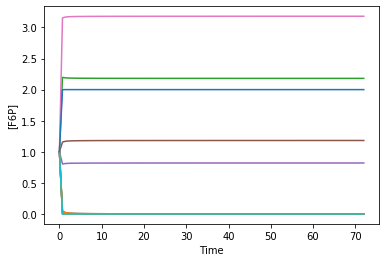

In [39]:
import matplotlib.pyplot as plt
plt.plot(timepoints_ode, sol)
plt.xlabel('Time')
plt.ylabel('[F6P]')
plt.show()

In [40]:
from auto_reduce.utils import get_SSM
timepoints_ssm = np.linspace(0,100,10)
sys_ssm = get_SSM(sys, timepoints_ssm)
Ss = sys_ssm.compute_SSM() # len(timepoints) x len(params) x len(states)
out_Ss = []
for i in range(len(params)):
    out_Ss.append((np.array(C)@(Ss[:,i,:].T)))
out_Ss = np.reshape(np.array(out_Ss), (len(timepoints_ssm), len(params), nouts))

KeyboardInterrupt: 

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


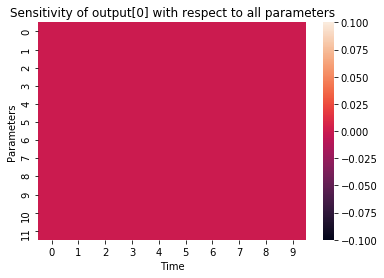

In [15]:
import seaborn as sn
for j in range(nouts):
    sn.heatmap(out_Ss[:,:,j].T)
    plt.xlabel('Time')
    plt.ylabel('Parameters')
    plt.title('Sensitivity of output[{0}] with respect to all parameters'.format(j))
    plt.show()

In [44]:
sys_reduce.nstates_tol_min?

Type:        int
String form: 1
Docstring:  
int([x]) -> integer
int(x, base=10) -> integer

Convert a number or string to an integer, or return 0 if no arguments
are given.  If x is a number, return x.__int__().  For floating point
numbers, this truncates towards zero.

If x is not a number or if base is given, then x must be a string,
bytes, or bytearray instance representing an integer literal in the
given base.  The literal can be preceded by '+' or '-' and be surrounded
by whitespace.  The base defaults to 10.  Valid bases are 0 and 2-36.
Base 0 means to interpret the base from the string as an integer literal.
>>> int('0b100', base=0)
4


In [45]:
from auto_reduce.utils import reduce
timepoints_ssm = np.linspace(0,100,10)
timepoints_ode = np.linspace(0, 100, 100)
sys_reduce = reduce(sys, timepoints_ode, timepoints_ssm)
sys_reduce.nstates_tol_min = 4 # make sure more states than 4
sys_reduce.nstates_tol = 9 # make sure less than 9
results = sys_reduce.reduce_simple()

attempting reduced states index: [0, 1, 2, 10]


/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/sympy/core/relational.py:470: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  deprecated_since_version="1.5"


KeyboardInterrupt: 

In [56]:
# can fix species at qss
aa,bb = sys_reduce.solve_timescale_separation([x[0], x[1], x[2], x[5], x[6], x[7], x[10]]) #3,4,8,9
# from sympy import solve, Eq
# collapse = solve(Eq(bb.f[0]), x[0])
# aa.f[0] = aa.f[0].subs(x[0], collapse)

attempting reduced states index: [0, 1, 2, 5, 6, 7, 10]
Successful time-scale separation solution obtained.


In [60]:
sys_reduce.get_error_metric(aa)

9.949864822520633

In [57]:
aa.get

[-P0*x0*x1*x2 + P1*(P0*x0*x1*x2 + P3*x2*(P0*P2*x0*x1 + P1*P5*x5*x6 + P5*P8*x5*x6)/(P1*P3 + P1*P4 - P2*P3 + P3*P8 + P4*P8))/(P1 + P8),
 -P0*x0*x1*x2 + P1*(P0*x0*x1*x2 + P3*x2*(P0*P2*x0*x1 + P1*P5*x5*x6 + P5*P8*x5*x6)/(P1*P3 + P1*P4 - P2*P3 + P3*P8 + P4*P8))/(P1 + P8),
 -P0*x0*x1*x2 + P1*(P0*x0*x1*x2 + P3*x2*(P0*P2*x0*x1 + P1*P5*x5*x6 + P5*P8*x5*x6)/(P1*P3 + P1*P4 - P2*P3 + P3*P8 + P4*P8))/(P1 + P8) + P4*x2*(P0*P2*x0*x1 + P1*P5*x5*x6 + P5*P8*x5*x6)/(P1*P3 + P1*P4 - P2*P3 + P3*P8 + P4*P8) - P5*x2*x5*x6,
 P10*(P6*x5*x7 + P9*x7*(P11*P7*x10 + P11*P8*x10 + P6*P9*x5)/(P10*P7 + P10*P8 + P7*P9 + P8*P9 - P9**2))/(P7 + P8) + P4*x2*(P0*P2*x0*x1 + P1*P5*x5*x6 + P5*P8*x5*x6)/(P1*P3 + P1*P4 - P2*P3 + P3*P8 + P4*P8) - P5*x2*x5*x6 - P6*x5*x7,
 P4*x2*(P0*P2*x0*x1 + P1*P5*x5*x6 + P5*P8*x5*x6)/(P1*P3 + P1*P4 - P2*P3 + P3*P8 + P4*P8) - P5*x2*x5*x6,
 P10*x7*(P11*P7*x10 + P11*P8*x10 + P6*P9*x5)/(P10*P7 + P10*P8 + P7*P9 + P8*P9 - P9**2) - P11*x10*x7 - P6*x5*x7 + P7*(P6*x5*x7 + P9*x7*(P11*P7*x10 + P11*P8*x10 + 

In [58]:
aa.x

[x0, x1, x2, x5, x6, x7, x10]

Taking a while to run

In [22]:
#watermark
%reload_ext watermark
%watermark -v -p numpy,bokeh,auto_reduce,sympy,jupyterlab

CPython 3.7.7
IPython 7.13.0

numpy 1.18.1
bokeh 2.0.2
auto_reduce unknown
sympy 1.5.1
jupyterlab 1.2.6
